## SignatureVectorizer Example Notebook 1
In this notebook we explore four paths in 2D space, and use these paths to demonstrate some properties of the path signature.

In python we represent a path as a matrix of shape path_length x path_dimension. When we use the vectorizers library to compute path signatures we submit a collection of paths, which is either a list of paths, or a numpy array of shape num_paths x path_length x path_dimension.

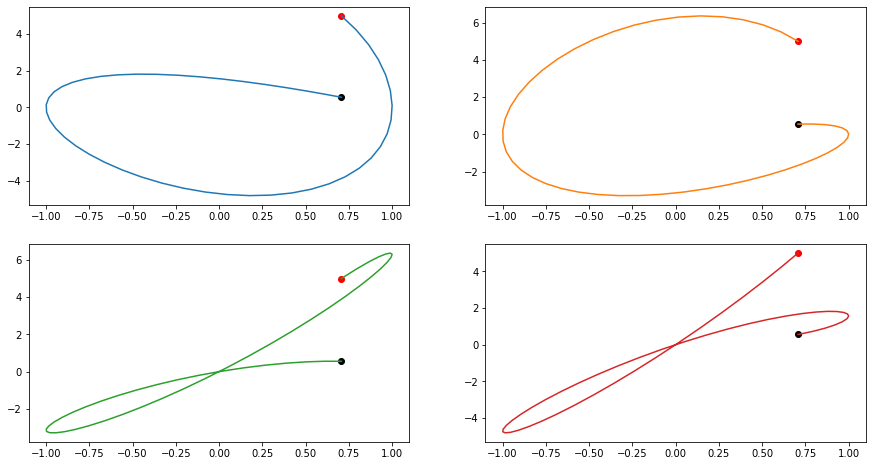

In [1]:
import numpy as np
from matplotlib import pyplot as plt

t = np.linspace(0.78539816,0.78539816+np.pi*2)
A = lambda t: np.array([np.cos(t),t*np.sin(t)]).T
B = lambda t: np.array([np.sin(t),t*np.cos(t)]).T
C = lambda t: np.array([np.cos(t),t*np.cos(t)]).T
D = lambda t: np.array([np.sin(t),t*np.sin(t)]).T

curves = [A,B,C,D]
fig,axs = plt.subplots(2,2,figsize=(15,8))
axs=axs.flatten()
for i,(ax,curve) in enumerate(zip(axs,curves)):
    ax.plot(*curve(t).T,c=plt.cm.tab10.colors[i])
    ax.scatter(*curve(t[0]),c='k')
    ax.scatter(*curve(t[-1]),c='r')
            #,B(t[0])],'o')
plt.show()

In [2]:
# A(t) returns a path of length 50, dimension 2
A(t).shape

(50, 2)

## Varying the truncation level
A key parameter in the path signature transform is the truncation level (tau). This parameter determines the length of the signature (higher tau -> larger signature). 

If your path has dimension d, and you pick truncation level tau, then the signature will be of length d+d^2+...d^tau = (d^(tau+1)-1)/(d-1)-1.

The first level of the signature is just the increment of the path. Since these four paths start and end at the same points, the increment (and hence first level of the signature) should be the same.
Let's verify this using iisignature via the vectorizers library.

In [3]:
import vectorizers
signaturizer = vectorizers.SignatureVectorizer(truncation_level=1)
sigs = signaturizer.fit_transform([A(t),B(t),C(t),D(t)])
for i in range(3):
    assert np.all( np.isclose(sigs[i],sigs[i+1]) )    
sigs


array([[-3.33066907e-16,  4.44288292e+00],
       [ 1.11022302e-16,  4.44288295e+00],
       [-3.33066907e-16,  4.44288295e+00],
       [ 1.11022302e-16,  4.44288292e+00]])

The second level is enough to differentiate between curves A and B, but it is not enough to distinguish curve C and D.

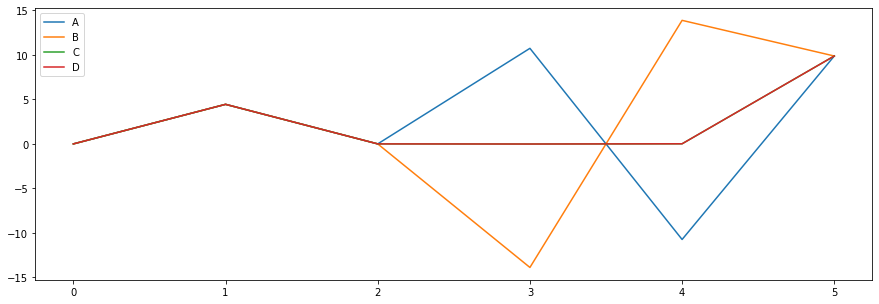

In [4]:
signaturizer = vectorizers.SignatureVectorizer(truncation_level=2)
sigs = signaturizer.fit_transform([A(t),B(t),C(t),D(t)])
fig,ax = plt.subplots(figsize=(15,5))
names = ['A','B','C','D']
for name,sig in zip(names,sigs):
    ax.plot(sig,label=name)
ax.legend()
plt.show()

assert np.all( np.isclose(sigs[2],sigs[3]) ) 

At the third level of the signature, diffences between curves C and D become apparent (although they are still close).

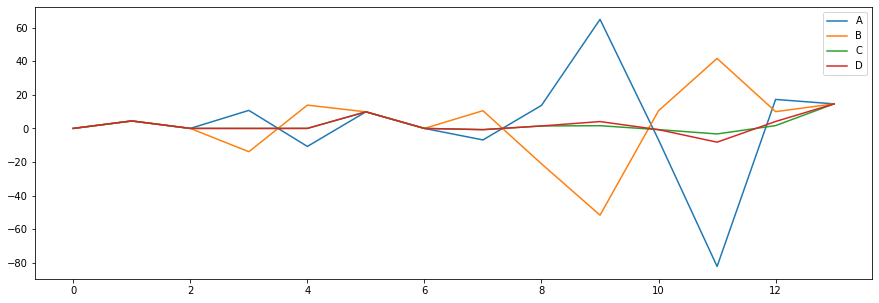

In [5]:
signaturizer = vectorizers.SignatureVectorizer(truncation_level=3)
sigs = signaturizer.fit_transform([A(t),B(t),C(t),D(t)])
fig,ax = plt.subplots(figsize=(15,5))
names = ['A','B','C','D']
for name,sig in zip(names,sigs):
    ax.plot(sig,label=name)
ax.legend()
plt.show()

## Translation Invariance
A nice propery of the path signature is that it allows for translations without perurbing the signature, i.e. any translational shift of the path will not be detected by the signature, as evidenced in the example below.

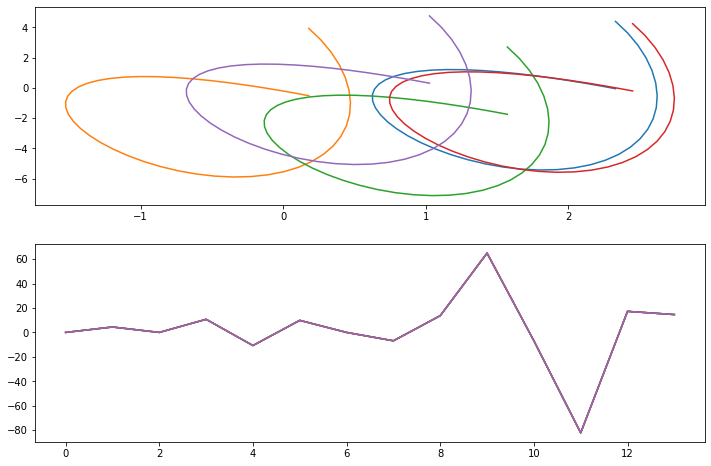

In [6]:
np.random.seed(1)
paths = [A(t)+np.random.normal(size=(2)) for i in range(5)]
fig,axs = plt.subplots(2,1,figsize=(12,8))
axs=axs.flatten()
for path in paths:
    axs[0].plot(*path.T)
    
sigs = vectorizers.SignatureVectorizer(truncation_level=3).fit_transform(paths)
assert np.all(np.isclose( (np.diff(sigs,axis=0)) , 0))

axs[1].plot(sigs.T)
plt.show()

In [7]:
sigs = vectorizers.SignatureVectorizer(truncation_level=3).fit_transform(paths)
assert np.all(np.isclose( (np.diff(sigs,axis=0)) , 0))

If we do care about translational shifts, then we can anchor all our paths at a basepoint, i.e. prepend all our paths with the zero vector. This can be done by setting the flag ```basepoint=True```

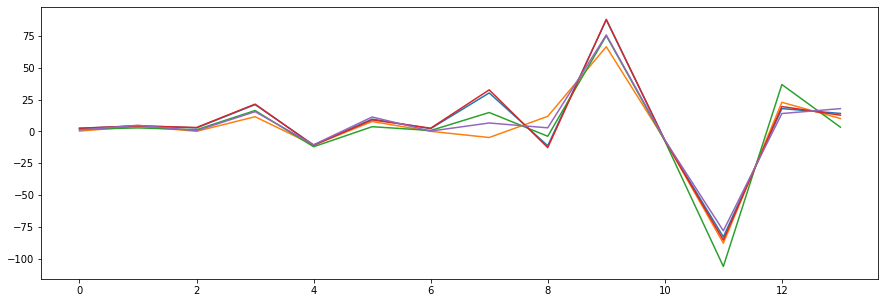

In [8]:
# Set each path to start at the basepoint
sigs = vectorizers.SignatureVectorizer(truncation_level=3,basepoint=True).fit_transform(paths)

# plot paths to demonstrate the signatures are now different
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(sigs.T)
plt.show()

## Log signatures
There is some redundant information in the path signature. For example, there are terms in the second level that are equal to half the square of terms in the first level.
Generally these relationships arrise from the shuffle product identity (see https://arxiv.org/pdf/1603.03788.pdf Section 1.3.2).

In [9]:
paths = [A(t),B(t),C(t),D(t)]
sigs = vectorizers.SignatureVectorizer(truncation_level=3).fit_transform(paths)

assert np.all(np.isclose(0.5*sigs[:,0]**2,  sigs[:,2]))
assert np.all(np.isclose(0.5*sigs[:,1]**2,  sigs[:,5]))
assert np.all(np.isclose(sigs[:,0]**3/6,  sigs[:,6]))
assert np.all(np.isclose(sigs[:,3]*sigs[:,1],  sigs[:,11]+sigs[:,9]+sigs[:,9]))

The Log signature is a compressed version of the path signature which eliminates the redundant information. In other words, the log signature is a smaller vector than the path signature, which can be used to perfectly reconstruct the path signature.
In vectorizers, we get the log signature by setting the flag log=True.

In [10]:
print('Path Signature Shape:', sigs.shape)

log_sigs = vectorizers.SignatureVectorizer(truncation_level=3, log=True).fit_transform(paths)
print('Log Signature Shape:', log_sigs.shape)


Path Signature Shape: (4, 14)
Log Signature Shape: (4, 5)


We see that the dimenion of the example above is reduced from 14 dimensions to 5.

## Irregular Sampling
The signature is relatively robust to different samplings of the path. In this example, we take some irregular samplings along curve A, and compute the signature. We will notice that the signatures are quite similar since the underlying path was the same.
(Note that the irregular samples do not have to be the same length!)

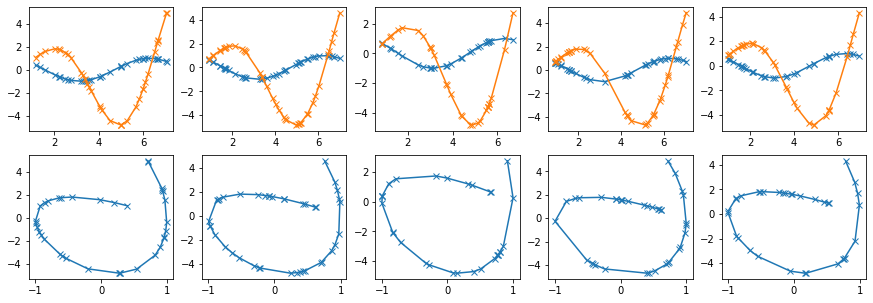

In [11]:
# Take 5 different irregular samplings of curve A
np.random.seed(1)
T = [np.sort(2*np.pi*np.random.random(size=np.random.randint(30,45))+0.78539816) for i in range(5)]
AT = [A(_T) for _T in T]
fig,axs = plt.subplots(2,5,figsize=(15,5))
axs=axs.flatten()

for i,(_T,_AT) in enumerate((zip(T,AT))):
    axs[i].plot(_T,_AT,'-x')
    axs[i+5].plot(*_AT.T,'-x')

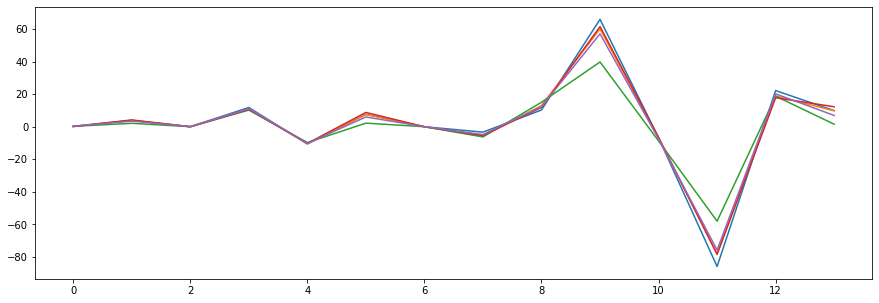

In [12]:
# Compare the signatures of each of the paths
signaturizer = vectorizers.SignatureVectorizer(truncation_level=3)
sigs = signaturizer.fit_transform(AT)
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(sigs.T)
plt.show()

## Visualisation with UMAP
Now we take a collection of paths, which are noisy, irregularly sampled realisations of the four underlying curves above. We show that the path signature can be combined with UMAP to produce an effective visualisation of the dataset.

In [13]:
#Create the dataset
np.random.seed(1)
N=1000
T = [np.sort(2*np.pi*np.random.random(size=np.random.randint(30,45))+0.78539816) for i in range(N)]
y = np.random.randint(len(curves),size=N)
X = [curves[y[i]](T[i])+np.random.normal(size=(len(T[i]),2),scale=0.05) for i in range(N)]

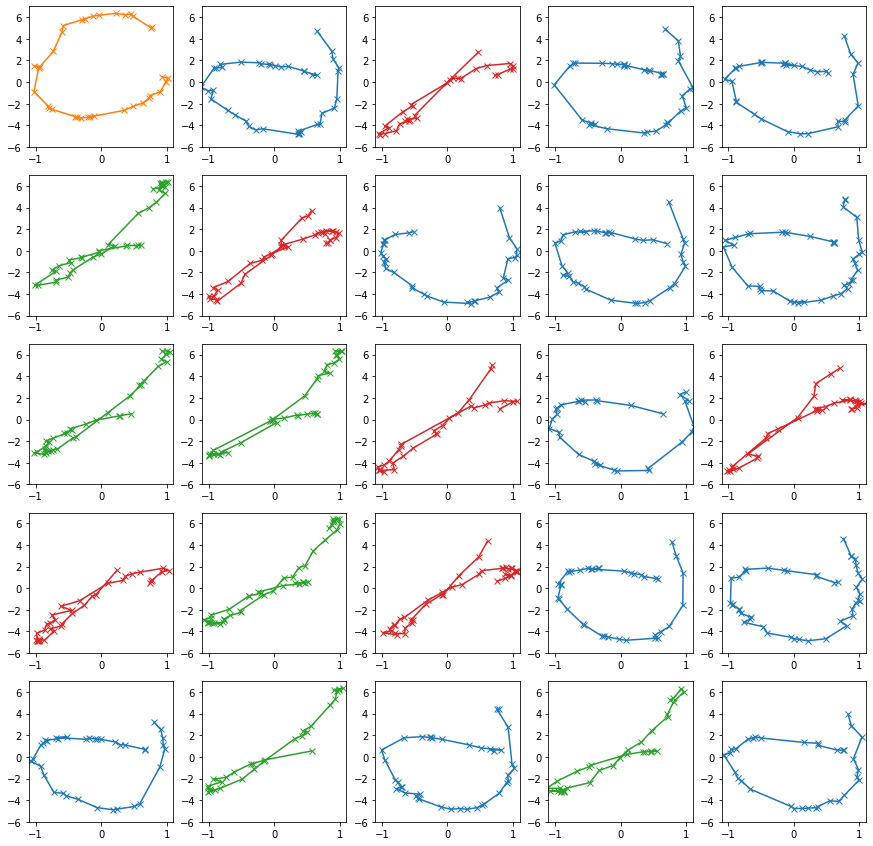

In [14]:
#Plot some curves from the dataset
fig,axs = plt.subplots(5,5,figsize=(15,15))
axs=axs.flatten()
for ax,t,path,label in zip(axs,T,X,y):
    ax.plot(*path.T,'-x',c=plt.cm.tab10.colors[label])
    ax.set_xlim(-1.1,1.1)
    ax.set_ylim(-6,7)

plt.show()

In [15]:
# Vectorize!
signaturizer = vectorizers.SignatureVectorizer(truncation_level=3,log=True)
signaturizer.fit(X)
sigs = signaturizer.transform(X)


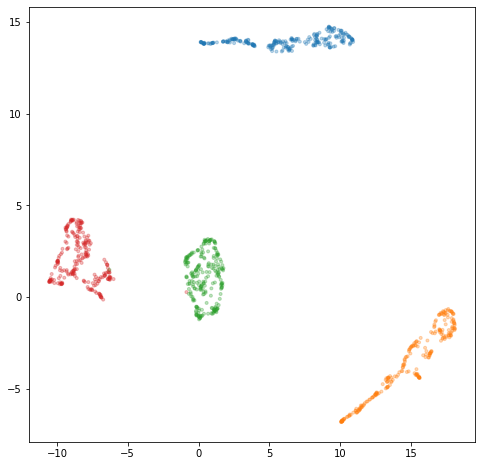

In [16]:
from umap import UMAP
U = UMAP(random_state=1).fit_transform(sigs)
fig,ax = plt.subplots(figsize=(8,8))
ax.scatter(*U.T,c=y,cmap=plt.cm.tab10,vmin=0,vmax=9,alpha=0.3,marker='.')
plt.show()